In [2]:
%matplotlib inline
import api
import helpers
import evaluation
import implementations
import split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [3]:
y, x, _ = helpers.load_csv_data('data/train.csv', sub_sample = True, background_value = -1)

In [4]:
# split data into 8 group
split_train = split.split(y, x, method='jet')

In [ ]:
## graphical representation of parameter search
## SLOW !!

ws = []
tr_losses = []
te_losses = []
accus = []

degrees = range(2, 15)
lambdas = np.logspace(-5, 2, 7)

#degrees = range(0, 2)
#lambdas = np.logspace(-5, 0, 3)

plt.figure(1, figsize=(15, 15))

for i, splitted_set in enumerate(split_train):
    # contain best_lambda, best_degree and best_teloss
    best = 0, 0, float("inf"), 0
    sub_y, sub_x, id_indices = splitted_set # jet 0 with no mass

    for l in lambdas:
        ws = []
        tr_losses = []
        te_losses = []
        accus = []

        for degree in degrees:
            w, tr_loss, te_loss, accu = api._inner_train(sub_y, sub_x, poly = degree, replace='median', cv=True, cut=0.,\
                                                 model_func=implementations.ridge_regression, \
                                                lambda_=l)
            ws.append(w)
            tr_losses.append(tr_loss)
            te_losses.append(te_loss)
            accus.append(accu)
            if te_loss < best[2]:
                best = (l, degree, te_loss, accu)

        plt.subplot(4,2,i+1)
        plt.xlabel("degree")
        plt.ylabel("test loss")
        plt.plot(degrees, te_losses)
        plt.plot(degrees, tr_losses)
        
        axes = plt.gca()
        #axes.set_xlim([xmin,xmax])
        axes.set_ylim([0,1])
        
    print("-------------------------------------")
    print("Set", i, ":")
    print("-------------------------------------")
    print("lambda*:", best[0])
    print("degree: ", best[1])
    print("test set loss: ", best[2])
    print("accuracy: ", best[3])
    
    
plt.savefig('test_fig.pdf', format='pdf')
plt.show()

-------------------------------------
Set 0 :
-------------------------------------
lambda*: 1e-05
degree:  3
test set loss:  0.678599120622
accuracy:  0.835685483871


In [233]:
# automatical search for best parameter (2 times zoom)
# in practice, not better than graphical solution. Maybe limit the degree to be under 4 could help and avoid overfit

# can be optimized on accuracy (beware of overfitting) or on test loss

import search_parameters
lambdas_star, degrees_star = search_parameters.search(y, x, optimize_on="accu")

-------------------------------------
Set 0
-------------------------------------
lambda*: 0.0120679328807
degree:  3
accuracy:  0.948214285714
-------------------------------------
Set 1
-------------------------------------
lambda*: 0.0100000444561
degree:  2
accuracy:  0.764788732394
-------------------------------------
Set 2
-------------------------------------
lambda*: 0.0100513176117
degree:  3
accuracy:  0.889534883721
-------------------------------------
Set 3
-------------------------------------
lambda*: 0.0100000003199
degree:  14
accuracy:  0.707602339181
-------------------------------------
Set 4
-------------------------------------
lambda*: 0.0120716107795
degree:  2
accuracy:  0.852941176471
-------------------------------------
Set 5
-------------------------------------
lambda*: 0.0120679264092
degree:  3
accuracy:  0.713991769547
-------------------------------------
Set 6
-------------------------------------
lambda*: 0.163631264499
degree:  2
accuracy:  0.86111

best cut :  -0.01
accuracy :  0.806828127645


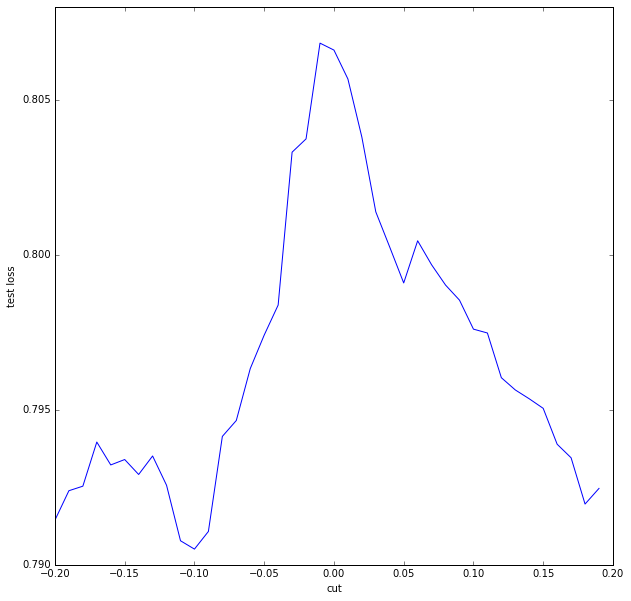

In [234]:
# test if an other cut is better
# most of time it only confirme that 0.0 is the better cut

LAMBDAS = lambdas_star
DEGREES = degrees_star

ws = []
cuts = np.arange(-0.2, 0.2, 0.01)
tr_losses = []
te_losses = []
accus = []

best = 0, 0

plt.figure(1, figsize=(10, 10))
for i in cuts:
    
    w = api.train(y, x, poly=DEGREES, split_method='mass', replace=None, cv=True, cut=i, \
               model_func=implementations.ridge_regression, lambdas = LAMBDAS)

    mean_accuracy = np.mean(np.array(w)[:,3])
    ws.append(mean_accuracy)
    
    if mean_accuracy > best[0]:
        best = (mean_accuracy, i)

          
print("best cut : ", best[1])
print("accuracy : ", best[0])
plt.xlabel("cut")
plt.ylabel("test loss")
plt.plot(cuts, ws)

plt.savefig('test_fig.pdf', format='pdf')
plt.show()

In [2]:
# load full dataset
y_full, x_full, _ = helpers.load_csv_data('data/train.csv', sub_sample = False, background_value = -1)

In [3]:
# train the model with chosen parameters

#LAMBDAS = lambdas_star
#DEGREES = degrees_star

LAMBDAS = [1.59985871961e-05, 3.23745754282e-05, 0.152641796718, 3.23745754282e-05, 0.0184206996933, 7.90604321091e-06, 0.625055192527, 0.00910298177992] 
DEGREES = [2, 2, 13, 2, 2, 3, 3, 3]

print("Kaggle summary")
print("method: mass, replace: None, method: RR")
print("lambdas: ", LAMBDAS)
print("degrees: ", DEGREES)

# check accuracy
w_cv = api.train(y_full, x_full, poly=DEGREES, split_method='mass', replace=None, cv=True, cut=0., 
               model_func=implementations.ridge_regression, lambdas = LAMBDAS)

print("accuracy mean :" ,np.mean(np.array(w_cv)[:,3]))
print("details: ", np.array(w_cv)[:,3])

# train de model
w = api.train(y_full, x_full, poly=DEGREES, split_method='mass', replace=None, cv=False, cut=0., 
               model_func=implementations.ridge_regression, lambdas = LAMBDAS)



Kaggle summary
method: mass, replace: None, method: RR
lambdas:  [1.59985871961e-05, 3.23745754282e-05, 0.152641796718, 3.23745754282e-05, 0.0184206996933, 7.90604321091e-06, 0.625055192527, 0.00910298177992]
degrees:  [2, 2, 13, 2, 2, 3, 3, 3]
accuracy mean : 0.830899851733
details:  [ 0.94375957  0.78665908  0.90674603  0.72360674  0.8699187   0.7767586
  0.9295393   0.71021079]


In [18]:
# load test set
test_y, test_x, test_ids = helpers.load_csv_data('data/test.csv')

In [19]:
# do the final prediction

final_pred = api.predict(test_y, test_x, test_ids, 0., w, poly=DEGREES, split_method='mass', \
            replace=None, loss_method='ls', res_to_file=True)

print("your done bro")

your done bro


In [1]:
# just to show how many Higgs there are in each dataset
# split data into 8 group
split_train = split.split(y_full, x_full, method='mass')
for num, i in enumerate(split_train):
    y, x, id_ = i
    n = np.count_nonzero(y == 1)
    print("Set",num,"  size",len(y), "  percent of Higgs", float(n) / float(len(y)))

NameError: name 'split' is not defined

In [13]:
a, b, c = split_train[0]